由于神经网络模型不能直接处理文本，因此我们需要先将文本转换为数字，这个过程被称为编码 (Encoding)，其包含两个步骤：

使用分词器 (tokenizer) 将文本按词、子词、字符切分为 tokens；
将所有的 token 映射到对应的 token ID。

# 分词策略
根据切分粒度的不同，分词策略可以分为以下几种：

按词切分 (Word-based)
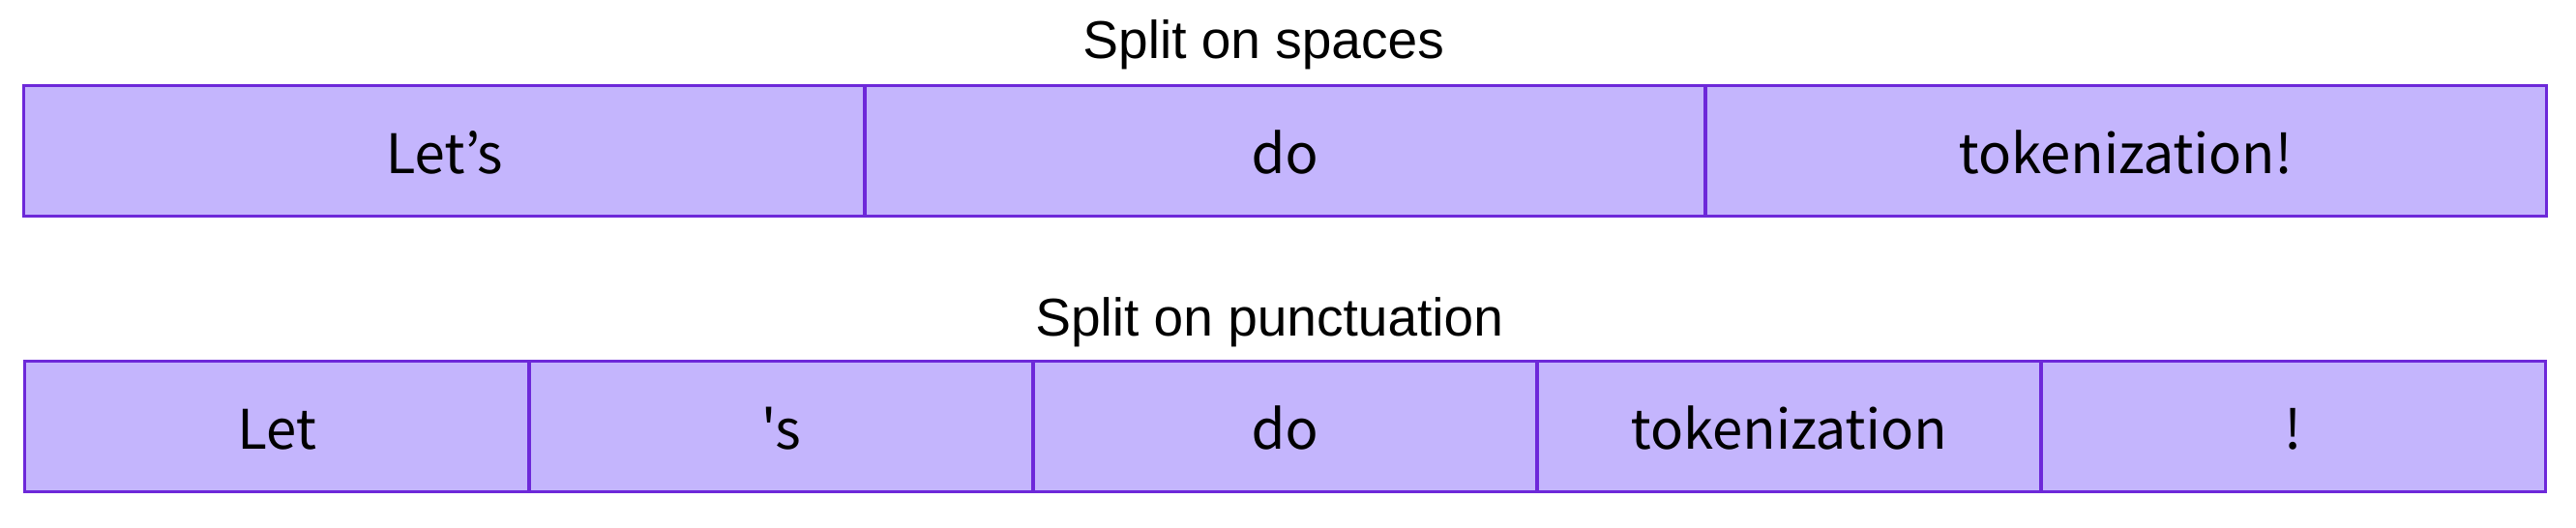
例如直接利用 Python 的 split() 函数按空格进行分词

In [1]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


这种策略的问题是会将文本中所有出现过的独立片段都作为不同的 token，从而产生巨大的词表。而实际上很多词是相关的，例如 “dog” 和 “dogs”、“run” 和 “running”，如果给它们赋予不同的编号就无法表示出这种关联性。

词表就是一个映射字典，负责将 token 映射到对应的 ID（从 0 开始）。神经网络模型就是通过这些 token ID 来区分每一个 token。

当遇到不在词表中的词时，分词器会使用一个专门的 
 token 来表示它是 unknown 的。显然，如果分词结果中包含很多 
 就意味着丢失了很多文本信息，因此一个好的分词策略，应该尽可能不出现 unknown token

# 按字符切分 (Character-based)

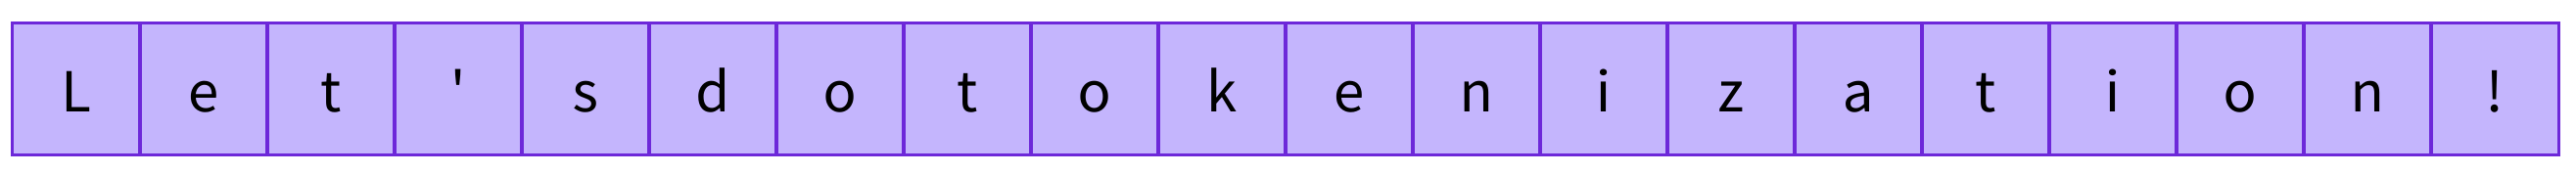

这种策略把文本切分为字符而不是词语，这样就只会产生一个非常小的词表，并且很少会出现词表外的 tokens。

但是从直觉上来看，字符本身并没有太大的意义，因此将文本切分为字符之后就会变得不容易理解。这也与语言有关，例如中文字符会比拉丁字符包含更多的信息，相对影响较小。此外，这种方式切分出的 tokens 会很多，例如一个由 10 个字符组成的单词就会输出 10 个 tokens，而实际上它们只是一个词。

因此现在广泛采用的是一种同时结合了按词切分和按字符切分的方式——按子词切分 (Subword tokenization)。

# 按子词切分 (Subword)

高频词直接保留，低频词被切分为更有意义的子词。例如 “annoyingly” 是一个低频词，可以切分为 “annoying” 和 “ly”，这两个子词不仅出现频率更高，而且词义也得以保留。下图展示了对 “Let’s do tokenization!“ 按子词切分的结果：

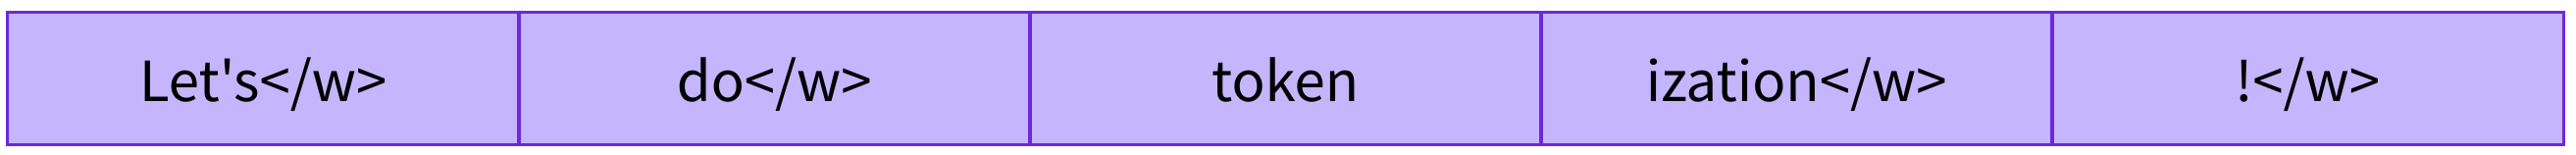
可以看到，“tokenization” 被切分为了 “token” 和 “ization”，不仅保留了语义，而且只用两个 token 就表示了一个长词。这种策略只用一个较小的词表就可以覆盖绝大部分文本，基本不会产生 unknown token。尤其对于土耳其语等黏着语，几乎所有的复杂长词都可以通过串联多个子词构成。

# 加载与保存分词器
分词器的加载与保存与模型相似，使用 Tokenizer.from_pretrained() 和 Tokenizer.save_pretrained() 函数。例如加载并保存 BERT 模型的分词器：

In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer.save_pretrained("./models/bert-base-cased/")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

('./models/bert-base-cased/tokenizer_config.json',
 './models/bert-base-cased/special_tokens_map.json',
 './models/bert-base-cased/vocab.txt',
 './models/bert-base-cased/added_tokens.json')

同样地，在大部分情况下我们都应该使用 AutoTokenizer 来加载分词器：

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer.save_pretrained("./models/bert-base-cased/")

调用 Tokenizer.save_pretrained() 函数会在保存路径下创建三个文件：
special_tokens_map.json：映射文件，里面包含 unknown token 等特殊字符的映射关系；
tokenizer_config.json：分词器配置文件，存储构建分词器需要的参数；
vocab.txt：词表，一行一个 token，行号就是对应的 token ID（从 0 开始）

编码与解码文本
前面说过，文本编码 (Encoding) 过程包含两个步骤：
+ 分词：使用分词器按某种策略将文本切分为 tokens；
+ 映射：将 tokens 转化为对应的 token IDs。
下面我们首先使用 BERT 分词器来对文本进行分词：

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


可以看到，BERT 分词器采用的是子词切分策略，它会不断切分词语直到获得词表中的 token，例如 “transformer” 会被切分为 “transform” 和 “##er”。

然后，我们通过 convert_tokens_to_ids() 将切分出的 tokens 转换为对应的 token IDs：

In [5]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)


[7993, 170, 13809, 23763, 2443, 1110, 3014]


还可以通过 encode() 函数将这两个步骤合并，并且 encode() 会自动添加模型需要的特殊 token，例如 BERT 分词器会分别在序列的首尾添加[CLS] 和[SEP] 
：

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
sequence_ids = tokenizer.encode(sequence)

print(sequence_ids)

[101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102]


其中 101 和 102 分别是 
[CLS] 和[SEP] 
 对应的 token IDs。
 注意，上面这些只是为了演示。在实际编码文本时，最常见的是直接使用分词器进行处理，这样不仅会返回分词后的 token IDs，还包含模型需要的其他输入。例如 BERT 分词器还会自动在输入中添加 token_type_ids 和 attention_mask：

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_text = tokenizer("Using a Transformer network is simple")
print(tokenized_text)

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


文本解码 (Decoding) 与编码相反，负责将 token IDs 转换回原来的字符串。注意，解码过程不是简单地将 token IDs 映射回 tokens，还需要合并那些被分为多个 token 的单词。下面我们通过 decode() 函数解码前面生成的 token IDs：

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

decoded_string = tokenizer.decode([101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102])
print(decoded_string)

Using a transformer network is simple
[CLS] Using a Transformer network is simple [SEP]


# 处理多文段
现实场景中，我们往往会同时处理多段文本，而且模型也只接受批 (batch) 数据作为输入，即使只有一段文本，也需要将它组成一个只包含一个样本的 batch，例如：

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
# input_ids = torch.tensor(ids), This line will fail.
input_ids = torch.tensor([ids])
print("Input IDs:\n", input_ids)

output = model(input_ids)
print("Logits:\n", output.logits)

Input IDs:
 tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits:
 tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


注意，上面的代码仅作为演示。实际场景中，我们应该直接使用分词器对文本进行处理，例如对于上面的例子：

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print("Inputs Keys:\n", tokenized_inputs.keys())
print("\nInput IDs:\n", tokenized_inputs["input_ids"])

output = model(**tokenized_inputs)
print("\nLogits:\n", output.logits)


Inputs Keys:
 dict_keys(['input_ids', 'attention_mask'])

Input IDs:
 tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])

Logits:
 tensor([[-1.5607,  1.6123]], grad_fn=<AddmmBackward0>)


可以看到，分词器输出的结果中不仅包含 token IDs（input_ids），还会包含模型需要的其他输入项。前面我们之所以只输入 token IDs 模型也能正常运行，是因为它自动地补全了其他的输入项，例如 attention_mask 等，后面我们会具体介绍。

由于分词器自动在序列的首尾添加了 
 和 
 token，所以上面两个例子中模型的输出是有差异的。因为 DistilBERT 预训练时是包含 
 和 
 的，所以下面的例子才是正确的使用方法。

# Padding 操作
按批输入多段文本产生的一个直接问题就是：batch 中的文本有长有短，而输入张量必须是严格的二维矩形，维度为 
，即每一段文本编码后的 token IDs 数量必须一样多。例如下面的 ID 列表是无法转换为张量的：
我们需要通过 Padding 操作，在短序列的结尾填充特殊的 padding token，使得 batch 中所有的序列都具有相同的长度，
模型的 padding token ID 可以通过其分词器的 pad_token_id 属性获得。下面我们尝试将两段文本分别以独立以及 batch 的形式送入到模型中：


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


问题出现了，使用 padding token 填充的序列的结果竟然与其单独送入模型时不同！

这是因为模型默认会编码输入序列中的所有 token 以建模完整的上下文，因此这里会将填充的 padding token 也一同编码进去，从而生成不同的语义表示。
因此，在进行 Padding 操作时，我们必须明确告知模型哪些 token 是我们填充的，它们不应该参与编码。这就需要使用到 Attention Mask 了，在前面的例子中相信你已经多次见过它了。
# Attension Mask
Attention Mask 是一个尺寸与 input IDs 完全相同，且仅由 0 和 1 组成的张量，0 表示对应位置的 token 是填充符，不参与计算。当然，一些特殊的模型结构也会借助 Attention Mask 来遮蔽掉指定的 tokens。

对于上面的例子，如果我们通过 attention_mask 标出填充的 padding token 的位置，计算结果就不会有问题了：


In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]
batched_attention_masks = [
    [1, 1, 1],
    [1, 1, 0],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
outputs = model(
    torch.tensor(batched_ids), 
    attention_mask=torch.tensor(batched_attention_masks))
print(outputs.logits)


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


正如前面强调的那样，在实际使用时，我们应该直接使用分词器对文本进行处理，它不仅会向 token 序列中添加模型需要的特殊字符（例如 
），还会自动生成对应的 Attention Mask。

目前大部分 Transformer 模型只能接受长度不超过 512 或 1024 的 token 序列，因此对于长序列，有以下三种处理方法：

+ 使用一个支持长文的 Transformer 模型，例如 Longformer 和 LED（最大长度 4096）；
+ 设定最大长度 max_sequence_length 以截断输入序列：sequence = sequence[:max_sequence_length]。
+ 将长文切片为短文本块 (chunk)，然后分别对每一个 chunk 编码。在后面的快速分词器中，我们会详细介绍。


# 直接使用分词器
正如前面所说，在实际使用时，我们应该直接使用分词器来完成包括分词、转换 token IDs、Padding、构建 Attention Mask、截断等操作。例如：

In [14]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

model_inputs = tokenizer(sequences)
print(model_inputs)

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


可以看到，分词器的输出包含了模型需要的所有输入项。对于 DistilBERT 模型，就是 input IDs（input_ids）和 Attention Mask（attention_mask）。

Padding 操作通过 padding 参数来控制：

padding="longest"： 将序列填充到当前 batch 中最长序列的长度；
padding="max_length"：将所有序列填充到模型能够接受的最大长度，例如 BERT 模型就是 512。

In [15]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

model_inputs = tokenizer(sequences, padding="longest")
print(model_inputs)

model_inputs = tokenizer(sequences, padding="max_length")
print(model_inputs)

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

截断操作通过 truncation 参数来控制，如果 truncation=True，那么大于模型最大接受长度的序列都会被截断，例如对于 BERT 模型就会截断长度超过 512 的序列。此外，也可以通过 max_length 参数来控制截断长度：

In [16]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

model_inputs = tokenizer(sequences, max_length=8, truncation=True)
print(model_inputs)

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


分词器还可以通过 return_tensors 参数指定返回的张量格式：设为 pt 则返回 PyTorch 张量；tf 则返回 TensorFlow 张量，np 则返回 NumPy 数组。例如：



In [17]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")
print(model_inputs)

model_inputs = tokenizer(sequences, padding=True, return_tensors="np")
print(model_inputs)


{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
{'input_ids': array([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662,
        12172,  2607,  2026,  2878,  2166,  1012,   102],
       [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


实际使用分词器时，我们通常会同时进行 padding 操作和截断操作，并设置返回格式为 Pytorch 张量，这样就可以直接将分词结果送入模型：

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
print(tokens)
output = model(**tokens)
print(output.logits)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>)


在 padding=True, truncation=True 设置下，同一个 batch 中的序列都会 padding 到相同的长度，并且大于模型最大接受长度的序列会被自动截断。


# 编码句子对
除了对单段文本进行编码以外（batch 只是并行地编码多个单段文本），对于 BERT 等包含“句子对”预训练任务的模型，它们的分词器都支持对“句子对”进行编码，例如：


In [20]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

inputs = tokenizer("This is the first sentence.", "This is the second one.")
print(inputs)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"])
print(tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'this', 'is', 'the', 'first', 'sentence', '.', '[SEP]', 'this', 'is', 'the', 'second', 'one', '.', '[SEP]']


此时分词器会使用 
 token 拼接两个句子，输出形式为“
”的 token 序列，这也是 BERT 模型预期的“句子对”输入格式。

返回结果中除了前面我们介绍过的 input_ids 和 attention_mask 之外，还包含了一个 token_type_ids 项，用于标记哪些 token 属于第一个句子，哪些属于第二个句子。如果我们将上面例子中的 token_type_ids 项与 token 序列对齐：
的 token type ID 都为 1。

如果我们选择其他模型，分词器的输出不一定会包含 token_type_ids 项（例如 DistilBERT 模型）。分词器只需保证输出格式与模型预训练时的输入一致即可。

实际使用时，我们不需要去关注编码结果中是否包含 token_type_ids 项，分词器会根据 checkpoint 自动调整输出格式，例如：



In [21]:

from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sentence1_list = ["First sentence.", "This is the second sentence.", "Third one."]
sentence2_list = ["First sentence is short.", "The second sentence is very very very long.", "ok."]

tokens = tokenizer(
    sentence1_list,
    sentence2_list,
    padding=True,
    truncation=True,
    return_tensors="pt"
)
print(tokens)
print(tokens['input_ids'].shape)

{'input_ids': tensor([[ 101, 2034, 6251, 1012,  102, 2034, 6251, 2003, 2460, 1012,  102,    0,
            0,    0,    0,    0,    0,    0],
        [ 101, 2023, 2003, 1996, 2117, 6251, 1012,  102, 1996, 2117, 6251, 2003,
         2200, 2200, 2200, 2146, 1012,  102],
        [ 101, 2353, 2028, 1012,  102, 7929, 1012,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
torch.Size([3, 18])
